In [15]:
from IPython import get_ipython
from IPython.display import display

In [16]:
!pip install scikit-surprise

# important libraries

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import SVD, Dataset, Reader
from surprise.model_selection import cross_validate
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix


In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Load Dataset

In [19]:
!ls "/content/drive/MyDrive/data/archive_11"


anime.csv  rating.csv


In [20]:
# Define the paths
anime_path = "/content/drive/MyDrive/data/archive_11/anime.csv"
rating_path = "/content/drive/MyDrive/data/archive_11/rating.csv"
# Load the dataset
anime_df = pd.read_csv("/content/drive/MyDrive/data/archive_11/anime.csv")
rating_df = pd.read_csv("/content/drive/MyDrive/data/archive_11/rating.csv")


In [21]:
print(anime_df.size)
print(rating_df.size)

86058
23441211


In [22]:
# Display the first few rows
print(anime_df.head())


   anime_id                              name  \
0     32281                    Kimi no Na wa.   
1      5114  Fullmetal Alchemist: Brotherhood   
2     28977                          Gintama°   
3      9253                       Steins;Gate   
4      9969                     Gintama&#039;   

                                               genre   type episodes  rating  \
0               Drama, Romance, School, Supernatural  Movie        1    9.37   
1  Action, Adventure, Drama, Fantasy, Magic, Mili...     TV       64    9.26   
2  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.25   
3                                   Sci-Fi, Thriller     TV       24    9.17   
4  Action, Comedy, Historical, Parody, Samurai, S...     TV       51    9.16   

   members  
0   200630  
1   793665  
2   114262  
3   673572  
4   151266  


In [23]:
print(rating_df.head())

   user_id  anime_id  rating
0        1        20      -1
1        1        24      -1
2        1        79      -1
3        1       226      -1
4        1       241      -1



# Data Cleaning

In [24]:
anime_df.dropna(inplace=True)  # Removing missing values
rating_df = rating_df[rating_df.rating != -1]  # Removing undefined ratings

Dataset size after cleaning

In [25]:
print(anime_df.size)
print(rating_df.size)

84119
19011723


# Exploratory Data Analysis

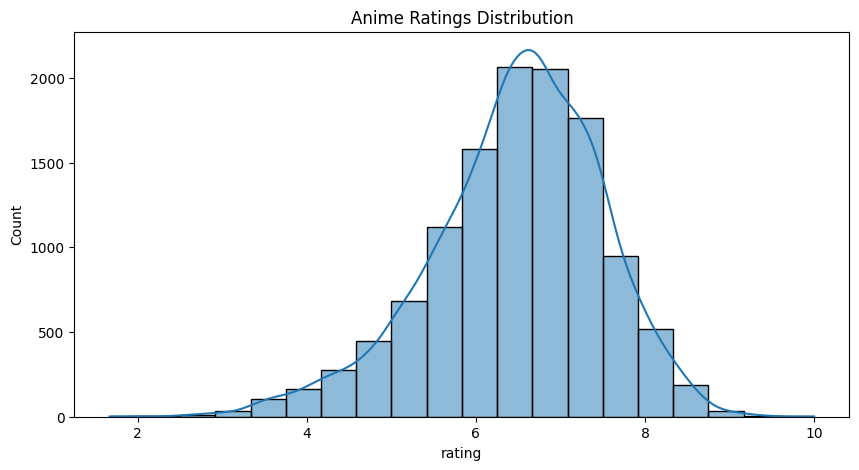

In [26]:
plt.figure(figsize=(10, 5))
sns.histplot(anime_df['rating'], bins=20, kde=True)
plt.title("Anime Ratings Distribution")
plt.show()

# Collaborative Filtering (User-Item Matrix)

In [27]:
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

#'rating_df' has columns 'user_id', 'anime_id', and 'rating'
user_item_sparse = csr_matrix((rating_df['rating'], (rating_df['user_id'], rating_df['anime_id'])))

knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(user_item_sparse)

# Find the 10 most similar users to user_id=1
distances, indices = knn.kneighbors(user_item_sparse[1], n_neighbors=10)
print(indices)

[[    1 71834  1776 46337 69976 64220 65558 33941  9825 71608]]


# Recommendation Function

In [28]:
def get_recommendations(user_id, model, num_recs=5):
    user_ratings = rating_df[rating_df['user_id'] == user_id]
    anime_ids = anime_df[~anime_df['anime_id'].isin(user_ratings['anime_id'])]['anime_id']
    preds = [model.predict(user_id, anime_id).est for anime_id in anime_ids]
    top_anime = np.argsort(preds)[-num_recs:]
    return anime_df.iloc[top_anime][['name', 'rating']]

# Show Recommendations

In [30]:
from surprise import SVD, Dataset, Reader

# Create and train the SVD model
reader = Reader(rating_scale=(1, 10))  # Define rating scale
data = Dataset.load_from_df(rating_df[['user_id', 'anime_id', 'rating']], reader)
trainset = data.build_full_trainset()
svd = SVD()  # Initialize the SVD model
svd.fit(trainset) # Train the SVD model
user_id = 1
print(get_recommendations(user_id, svd))  #'svd' is defined

                                            name  rating
333  Final Fantasy VII: Advent Children Complete    8.17
118                              No Game No Life    8.47
86                            Shingeki no Kyojin    8.54
0                                 Kimi no Na wa.    9.37
59    Steins;Gate Movie: Fuka Ryouiki no Déjà vu    8.61
